# Emcee exercise
Relevant Link: https://emcee.readthedocs.io/en/v2.2.1/user/line/#the-generative-probabilistic-model

In [109]:
import numpy as np
import matplotlib.pyplot as plt

In [110]:
m_true = -0.9594
b_true = 4.294
f_true = 0.534 

In [111]:
N = 50
x = np.sort(10*np.random.rand(N))
#np.sort: sorts the number in increasing order
#np.random.rand(): generates random numbers between [0.1) in the given shape

In [112]:
yerr = 0.1+0.5*np.random.rand(N) #Standard deviation, Gaussian uncertainty
y = m_true*x+b_true
y += np.abs(f_true*y) *np.random.randn(N) #?
y += yerr * np.random.randn(N) #? Measurement on y y_hat, randn(N):Gaussian of 1

[]

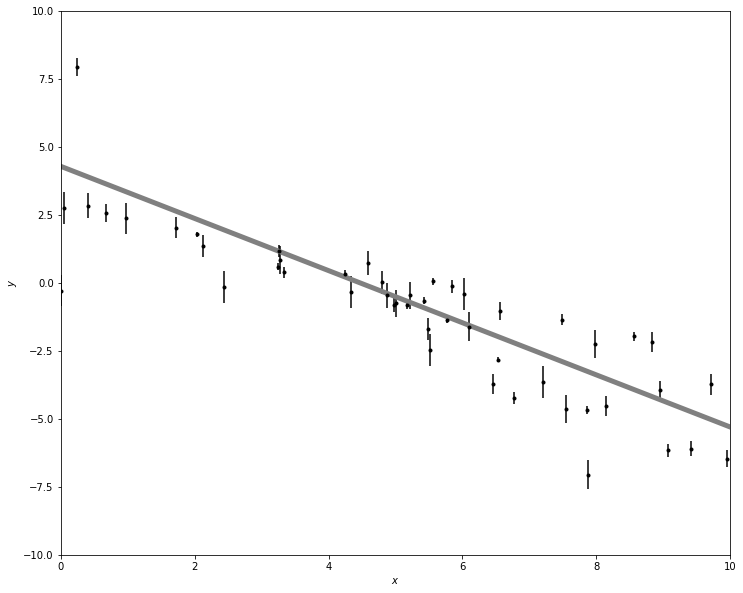

In [114]:
sample = np.arange(11)
plt.figure(figsize=(12,10))
plt.plot(sample,m_true*sample+b_true,'grey',linewidth=5)
plt.errorbar(x,y,yerr,fmt = '.k')
plt.xlim(0,10)
plt.ylim(-10,10)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot()

In [115]:
A = np.vstack((np.ones_like(x),x)).T #equation (3)
#np.ones_like(x): list of ones in the same shape as that of x
#np.vstack(tuple) stacks the tuple like below
#1  1  1  ... 1
#x1 x2 x3 ... x50
#np.T transposes an array

C = np.diag(yerr * yerr) #equation (4)
#np.diag extracts a diagonoal element

cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C,A)))  #First half of the righthand side of eq (5)
#np.linalg.solve: solves a system of equations given below
#CX = A
#Which is effectively same as C^-1 A 

b_ls, m_ls = np.dot(cov,np.dot(A.T, np.linalg.solve(C,y))) #equation 5 in Hogg, Bovy & Lang(2010)

[]

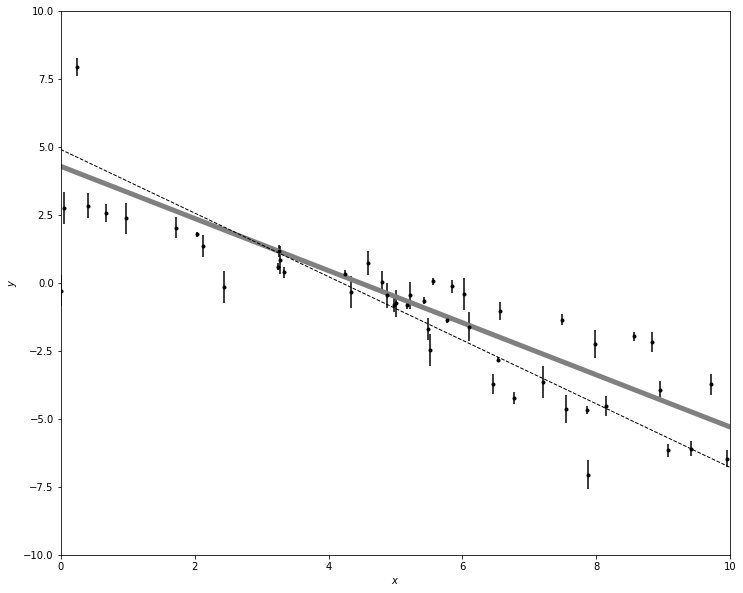

In [116]:
plt.figure(figsize=(12,10))
plt.plot(sample,m_true*sample+b_true,'grey',linewidth=5)
plt.errorbar(x,y,yerr,fmt = '.k')
plt.plot(sample,m_ls*sample+b_ls,'k', linestyle = 'dashed', linewidth = 1)
plt.xlim(0,10)
plt.ylim(-10,10)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot()

In [117]:
def lnlike(theta,x,y,yerr):
    m,b, lnf = theta
    model = m*x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    #inv_sigma2 is 1 over sigma squared
    #note the use of lnf
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

$ln\: p(y|x,\sigma,m,b,f) = -\frac{1}{2}\sum_{n} [\frac{(y_n-mx_n-b)^2}{{s_n}^2}+ln(2\pi{s_n}^2)]$

Where is $2\pi$ in the code? constant is usually ignored as it does not usually impact the result

In [124]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args) #negative likelihood
result = op.minimize(nll,[m_true,b_true,np.log(f_true)], args=(x,y,yerr))
#We minimize the negative likelihood to maximzie the likelihood
m_ml, b_ml, lnf_ml = result["x"]
op.minimize #find the minimum of the likelihood, distribute the walkers near the minimum, so that the walkers are distributed efficiently.

It’s worth noting that the optimize module minimizes functions whereas we would like to maximize the likelihood. This goal is equivalent to minimizing the negative likelihood (or in this case, the negative log likelihood). The maximum likelihood result is plotted as a solid black line—compared to the true model (grey line) and linear least squares (dashed line)—in the following figure:

[]

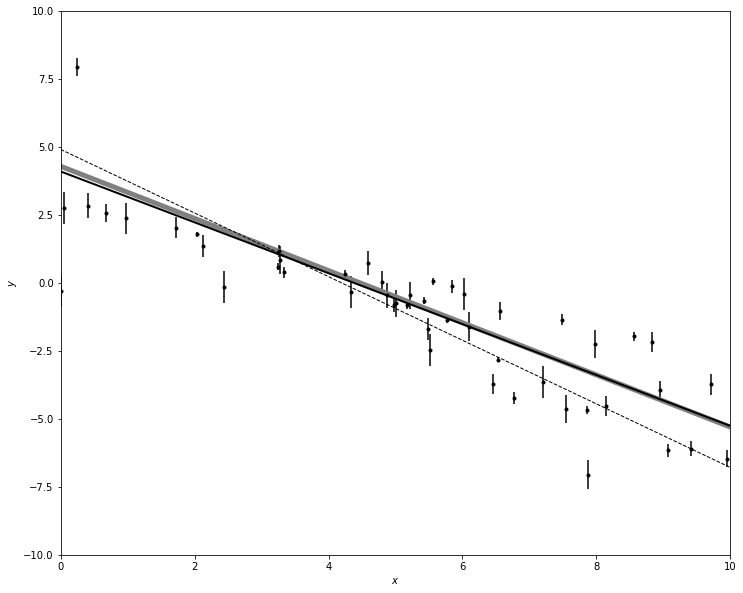

In [119]:
plt.figure(figsize=(12,10))
plt.plot(sample,m_true*sample+b_true,'grey',linewidth=5)
plt.errorbar(x,y,yerr,fmt = '.k')
plt.plot(sample,m_ls*sample+b_ls,'k', linestyle = 'dashed', linewidth = 1)
plt.plot(sample,m_ml*sample+b_ml,'k',linewidth = 2)
plt.xlim(0,10)
plt.ylim(-10,10)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot()

The problem now: how do we estimate the uncertainties on m and b? What’s more, we probably don’t really care too much about the value of f but it seems worthwhile to propagate any uncertainties about its value to our final estimates of m and b. This is where MCMC comes in.

In this example, we'll use uniform (so-called "Unfiromative") priors on m,b and the logarithm of f. For example, we'll use the following conservative prior on m:

$p(m) = \begin{cases}
1/5.5 & \text{if -5<m<1/2} \\
0 & \text{otherwise}
\end{cases}$


In [129]:
def lnprior(theta):
    m,b,lnf = theta
    if -5.0 < m <0.5 and 0.0 <b < 10.0 and -10.0 < lnf <1.0:
        #why does it have constraints on b and lnf?
        return 0
    return -np.inf #infinity

Combine this iwth the definition of lnlike from above.
Note:

$p(m,b,f|x,y,\sigma) \propto p(m,b,f)p(y|x,\sigma,m,b,f)$

In [128]:
def lnprob(theta,x,y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp): #if lp is infinite return -np.inf
        return -np.inf
    return lp + lnlike(theta,x,y,yerr) #if not ...

Now sample this distribution using emcee. Initialize the walkers in tiny Gaussian ball around he maximum likelihood result.

What is Gaussian Ball?

In [130]:
ndim, nwalkers = 3,100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [131]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (x,y,yerr))

In [141]:
sampler.run_mcmc(pos,500)

State([[-0.90613591  4.07476252 -0.34265706]
 [-0.94489413  4.23720004 -0.47998287]
 [-0.97756715  4.37559651 -0.58081105]
 [-0.83923259  3.6313429  -0.4765656 ]
 [-0.89602015  3.96537049 -0.36813291]
 [-0.96587472  4.05409087 -0.43003465]
 [-0.82477735  3.24254487 -0.43706188]
 [-0.9412822   4.32429826 -0.53825098]
 [-0.74948071  3.20256408 -0.30315427]
 [-0.83301093  3.54977083 -0.43054669]
 [-0.90605455  3.95100356 -0.43031066]
 [-0.89178095  3.74040352 -0.43441161]
 [-0.96034304  4.45206012 -0.20855648]
 [-0.97049393  4.21380218 -0.65057278]
 [-0.92000102  4.04444584 -0.26790017]
 [-0.9089396   3.94042211 -0.47476331]
 [-0.91798599  3.89536852 -0.39593272]
 [-0.88088735  3.73095962 -0.51261359]
 [-1.02803779  4.36328282 -0.53943516]
 [-0.92557361  3.95004944 -0.53489353]
 [-0.85591582  3.57237342 -0.54190001]
 [-1.01008662  4.50546898 -0.26938455]
 [-0.86866213  3.83588038 -0.06509378]
 [-0.9391113   3.86012707 -0.5839437 ]
 [-0.86935944  3.93546411 -0.38889415]
 [-1.03166701  4.51

In [134]:
samples = sampler.chain[:, 50:, :].reshape((-1,ndim))

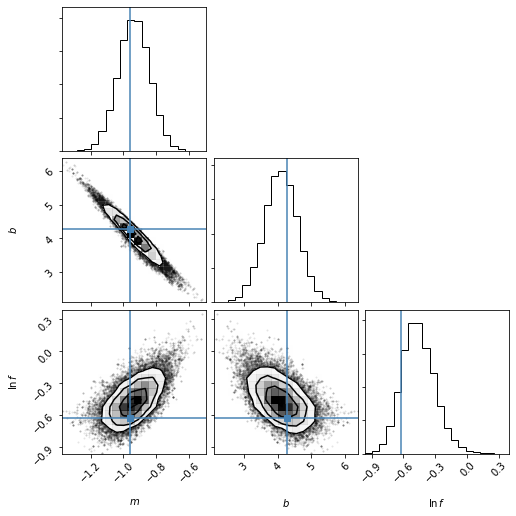

In [142]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],truths=[m_true,b_true, np.log(f_true)])

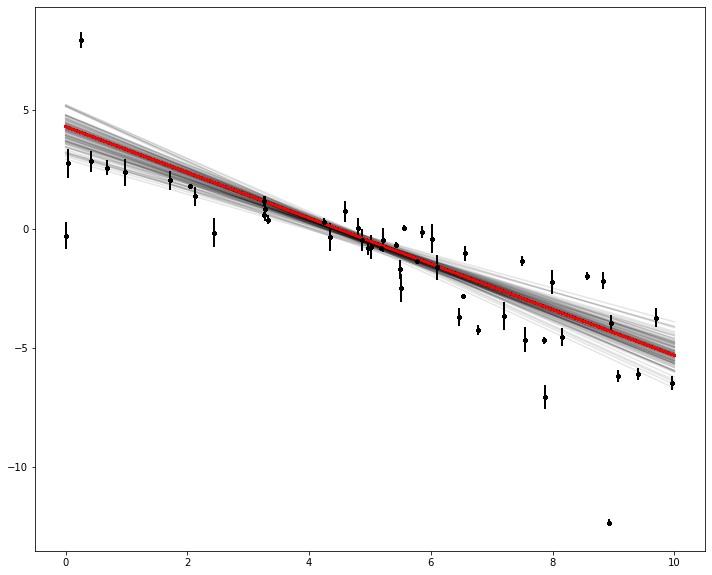

In [145]:
xl = np.array([0,10])
plt.figure(figsize=(12,10))
for m, b, lnf in samples[np.random.randint(len(samples),size=100)]:
    plt.plot(xl, m*xl+b, color = "k", alpha = 0.1)
    plt.plot(xl,m_true*xl+b_true, color = "r", lw=2, alpha = 0.8)
    plt.errorbar(x,y,yerr=yerr, fmt = ".k")

There are a few different options for this but my favorite is to quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions

In [147]:
samples[:,2] = np.exp(samples[:,2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16,50,84], axis = 0)))

In [149]:
print(m_mcmc)
print(b_mcmc)
print(f_mcmc)

(-0.9371393002816266, 0.09611232560936189, 0.09777536652969698)
(4.095041397537969, 0.4941137232757269, 0.4849016867275946)
(0.6247414699840201, 0.1092706444706022, 0.0820286732738158)
